In [4]:
import pandas as pd
%matplotlib notebook
import numpy as np

![axes](axes-definition.jpg)
![axes](axes_rocket.jpg)

In [5]:
mpu6000 = pd.read_csv('./20170520_roro1_testflight/imu_nosecone/mpu6000.csv', index_col='time')
liftoff = 1908.3
touchdown = 1990.15
separation = 1918.77
burnout = 1910
acc_calib = { # (bias, gain), acc = (sensor - bias) / gain
'x': (0, 1), # todo
'y': (0, 1),
'z': (0, 1)
}
gyro_bias = mpu6000[liftoff-30:liftoff-5].mean()[['gyro_'+a for a in ['x', 'y', 'z']]]

/usr/local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
mpu6000 = pd.read_csv('./20170520_roro1_testflight/imu_coupler_bay/mpu6000.csv', index_col='time')
liftoff = 2399.3
touchdown = 1990.15 - 1908.3 + 2399.3
separation = 1918.77 - 1908.3 + 2399.3
burnout = 1910 - 1908.3 + 2399.3
acc_calib = { # (bias, gain), acc = (sensor - bias) / gain
'x': (0.12570896416609578, 0.9984256389897912),
'y': (0.0031463042356696391, 0.99443041010383559),
'z': (-0.028494989398200055, 1.0144324415852917),
}
gyro_bias = mpu6000[liftoff-30:liftoff-5].mean()[['gyro_'+a for a in ['x', 'y', 'z']]]

/usr/local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [49]:
imu = pd.DataFrame()
for axis in ['x', 'y', 'z']:
    imu['acc_'+axis] = (mpu6000[liftoff-10:touchdown+10]['acc_'+axis] - acc_calib[axis][0])/acc_calib[axis][1]
    imu['rate_'+axis] = (mpu6000[liftoff-10:touchdown+10]['gyro_'+axis]) - gyro_bias['gyro_'+axis]

In [50]:
from quaternion import Quaternion
#imu = imu[liftoff-1: liftoff+5]
att = Quaternion([1,0,0,0])
prev_t = imu.index[0]
for t,frame in imu.iterrows():
    dt = t - prev_t
    prev_t = t
    imu.loc[t, 'dt'] = dt
    for i in range(4):
        imu.loc[t, 'q'+str(i)] = att.q[i]
    delta_att = Quaternion([1] + [dt / 2 * r for r in [frame.rate_x, frame.rate_y, frame.rate_z]])
    att = (att * delta_att).normalized()
    

In [51]:
# inertia and masses
m_liftoff = 18.283 # [kg]
m_burnout = 16.975 # [kg]
CM_liftoff = 1.567 # [m]
CM_burnout = 1.502 # [m]
Iz_liftoff = 0.0573 # [kgm2]
Iz_burnout = 0.0569 # [kgm2]
Ixy_liftoff = 8.6707 # [kgm2]
Ixy_burnout = 7.6265 # [kgm2]

def mass(time):
    if time < liftoff:
        return {'m':m_liftoff, 'CM':CM_liftoff, 'Iz':Iz_liftoff, 'Ixy':Ixy_liftoff}
    if time > burnout:
        return {'m':m_burnout, 'CM':CM_burnout, 'Iz':Iz_burnout, 'Ixy':Ixy_burnout}
    a = (time - liftoff)/(burnout-liftoff)
    return {'m':m_liftoff + a * (m_burnout-m_liftoff),
            'CM':CM_liftoff + a * (CM_burnout-CM_liftoff),
            'Iz':Iz_liftoff + a * (Iz_burnout-Iz_liftoff),
            'Ixy':Ixy_liftoff + a * (Ixy_burnout-Ixy_liftoff)}


In [59]:
# compensate for imu position with respect to CM
# assuming imu axes are aligned with the rocket
imu_pos = np.array([0.013, 0.005, 1.782])
imu_offset = lambda time: imu_pos - np.array([0, 0, mass(time)['CM']])
for a in ['x', 'y', 'z']:
    imu['rate_dot_'+a] = imu['rate_'+a].diff()/imu['dt']
    
# acceleration due to angular acceleration
#  a_rate_dot = rate_dot x imu_offset
# acceleration due to rotation (centripetal)
#  a_centripetal = - |rate_tangential|^2 * imu_offset
#  where rate_tangential is the tangential rate obtained by
#   rate - (dot(rate, imu_offset)/|imu_offset|^2 * imu_offset)
for t,i in imu.iterrows():
    r = imu_offset(t)
    rate_dot = np.array([i.rate_dot_x, i.rate_dot_y, i.rate_dot_z])
    a_rate_dot = np.cross(rate_dot, r)
    rate = np.array([i.rate_x, i.rate_y, i.rate_z])
    rate_tangential = rate - np.dot(rate, r)/np.dot(r,r)*r
    a_centripetal = - r * np.dot(rate_tangential, rate_tangential)
    imu.loc[t, 'a_rate_dot_x'] = a_rate_dot[0]
    imu.loc[t, 'a_rate_dot_y'] = a_rate_dot[1]
    imu.loc[t, 'a_rate_dot_z'] = a_rate_dot[2]
    imu.loc[t, 'a_centripetal_x'] = a_centripetal[0]
    imu.loc[t, 'a_centripetal_y'] = a_centripetal[1]
    imu.loc[t, 'a_centripetal_z'] = a_centripetal[2]

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:1819: RuntimeWarning: invalid value encountered in subtract
  cp0 -= tmp
/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:1822: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:1825: RuntimeWarning: invalid value encountered in subtract
  cp2 -= tmp


In [60]:
for a in 'xyz':
    imu['acc_cm_'+a] = imu['acc_'+a] - imu['a_rate_dot_'+a] - imu['a_centripetal_'+a]

<IPython.core.display.Javascript object>


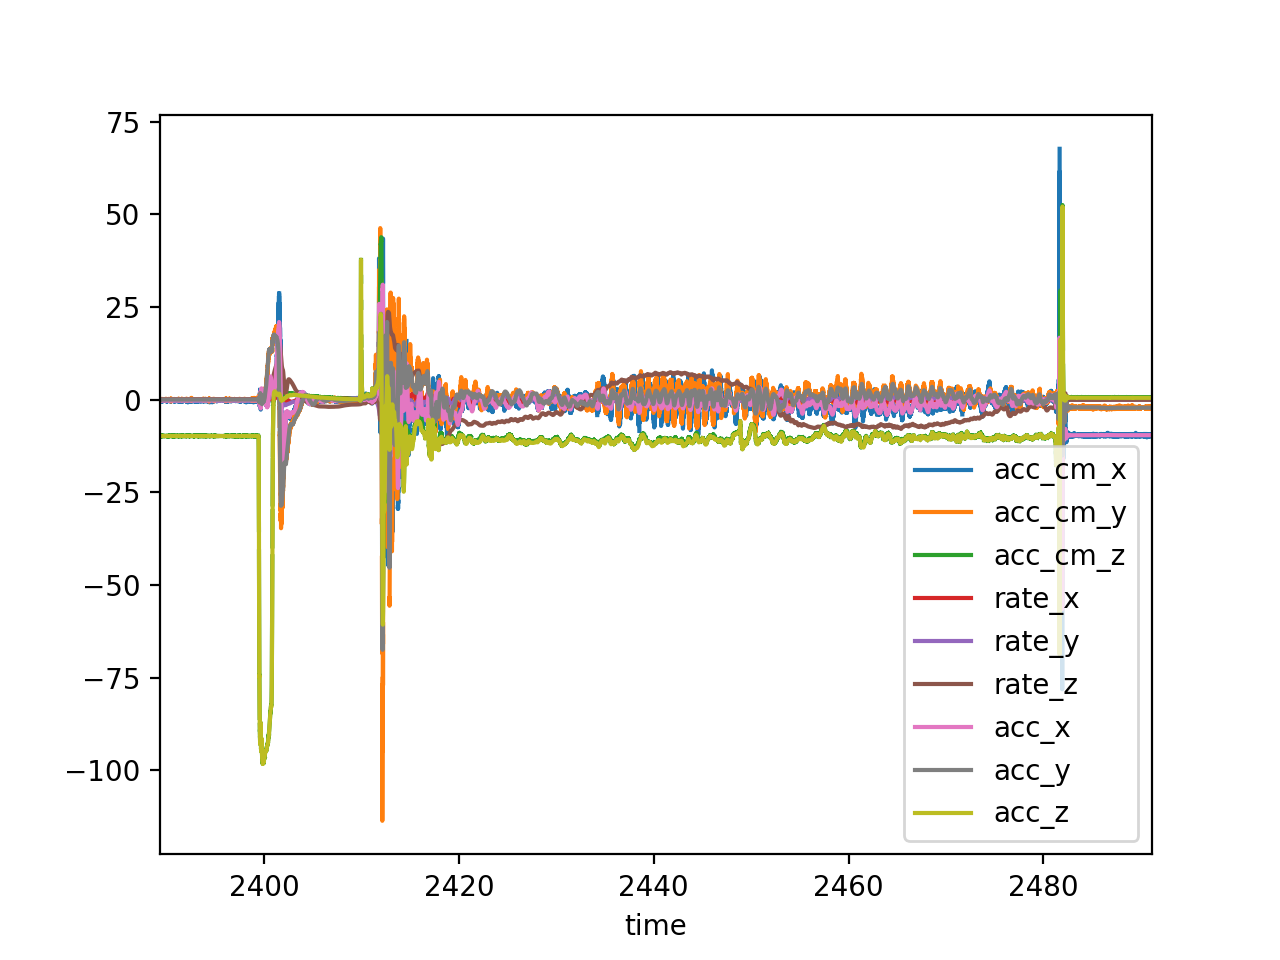

In [61]:
#imu[['a_centripetal_'+a for a in 'xyz'] + ['rate_'+a for a in 'xyz'] + ['acc_'+a for a in 'xyz']].plot()
imu[['acc_cm_'+a for a in 'xyz'] + ['rate_'+a for a in 'xyz'] + ['acc_'+a for a in 'xyz']].plot()


In [62]:
def body_to_inertial(att, v):
    return (att * Quaternion([0]+v) * att.conjugated()).q[1:4]

In [63]:
# compute side accelerations in inertial frame
att = Quaternion()
vel = np.array([0.0, 0.0, 0.0])
for t,i in imu.iterrows():
    att.q = [i.q0, i.q1, i.q2, i.q3]
    side_acc = body_to_inertial(att, [i.acc_cm_x, i.acc_cm_y, 0]) #use side accelerations at CM
    imu.loc[t, 'acc_side_inertial_x'] = side_acc[0]
    imu.loc[t, 'acc_side_inertial_y'] = side_acc[1]
    imu.loc[t, 'acc_side_inertial_z'] = side_acc[2]
    acc = body_to_inertial(att, [i.acc_x, i.acc_y, i.acc_z + 9.806]) # here we use the raw acceleration for lower noise
    vel += np.array(acc) * i['dt']
    imu.loc[t, 'vel_x'] = vel[0]
    imu.loc[t, 'vel_y'] = vel[1]
    imu.loc[t, 'vel_z'] = vel[2]

/Volumes/data/working/IREC/RORO/flight-data/quaternion.py:30: RuntimeWarning: invalid value encountered in double_scalars
  q[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3];
/Volumes/data/working/IREC/RORO/flight-data/quaternion.py:31: RuntimeWarning: invalid value encountered in double_scalars
  q[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2];
/Volumes/data/working/IREC/RORO/flight-data/quaternion.py:32: RuntimeWarning: invalid value encountered in double_scalars
  q[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1];
/Volumes/data/working/IREC/RORO/flight-data/quaternion.py:33: RuntimeWarning: invalid value encountered in double_scalars
  q[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0];


In [64]:
# compute external torque (in body axes) acting on the rocket (by rigid body dynamics)
for t,i in imu.iterrows():
    m = mass(t)
    Ixy = m['Ixy']
    Iz = m['Iz']
    imu.loc[t, 'M_x'] = Ixy*i.rate_dot_x + (Iz-Ixy)*i.rate_y*i.rate_z
    imu.loc[t, 'M_y'] = Ixy*i.rate_dot_y + (Ixy-Iz)*i.rate_z*i.rate_x
    imu.loc[t, 'M_z'] = Iz*i.rate_dot_z

In [75]:
# Compute the torque due to side forces assuming they are aerodynamic
# and thus act at the CP
CP = 1.764 # [m]
for t,i in imu.iterrows():
    m = mass(t)
    Fx = i.acc_cm_x * m['m']
    Fy = i.acc_cm_y * m['m']
    imu.loc[t, 'M_aero_x'] = (CP - m['CM']) * (-Fy)
    imu.loc[t, 'M_aero_y'] = (CP - m['CM']) * Fx

<IPython.core.display.Javascript object>


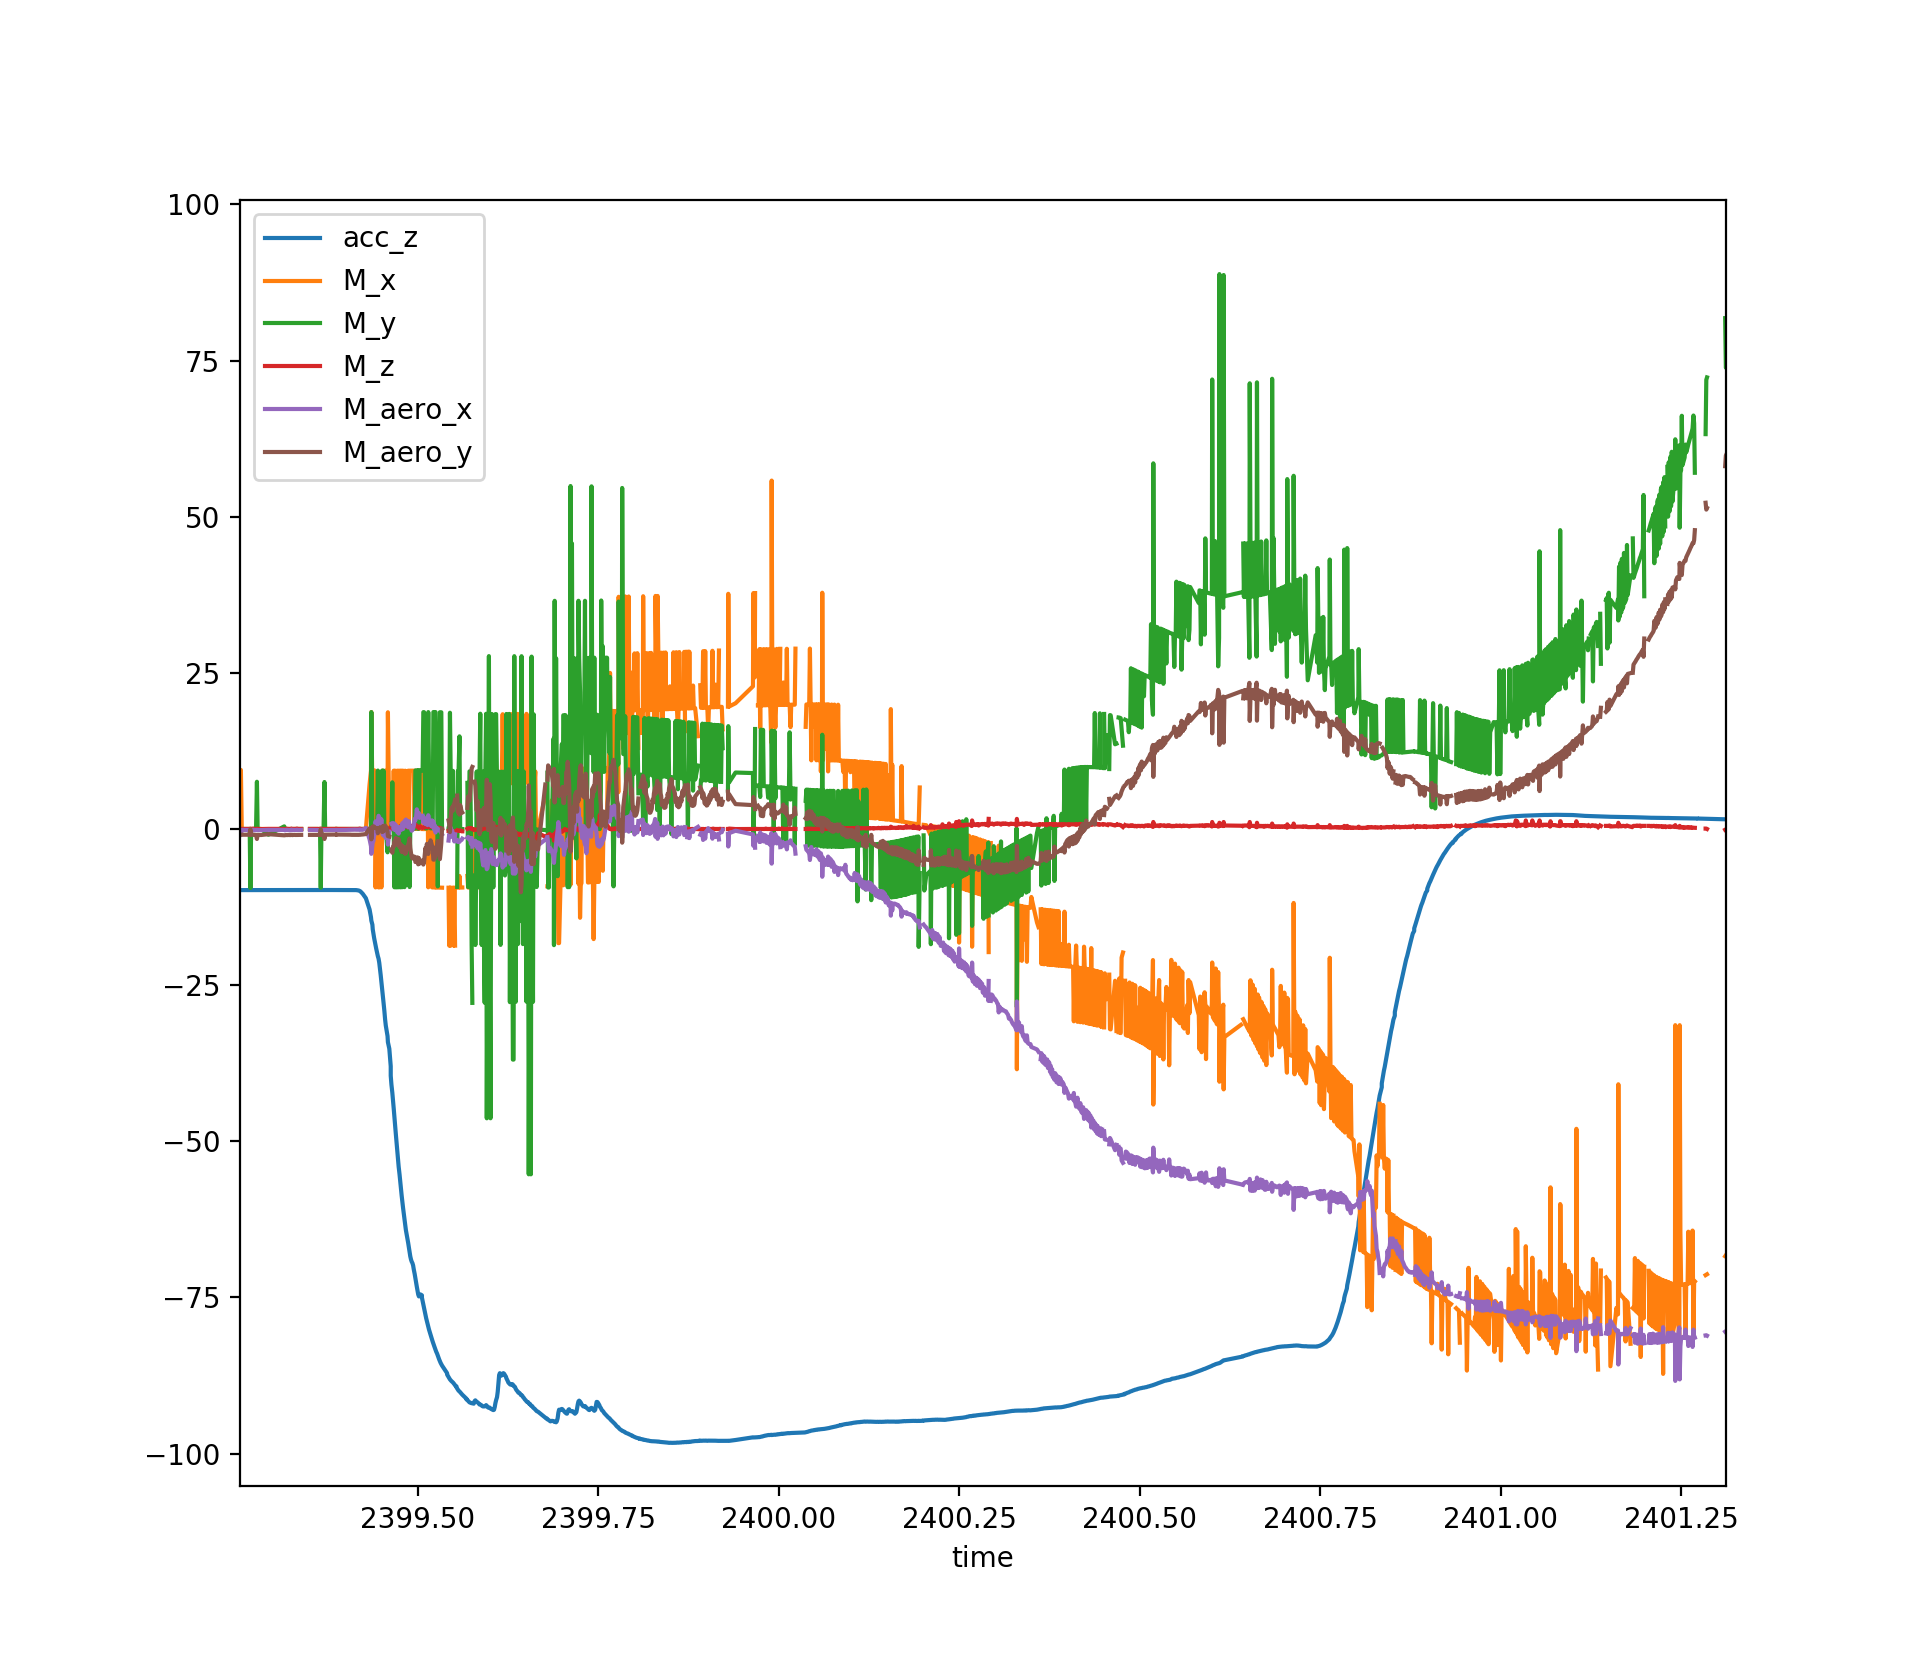

In [76]:
imu[['acc_'+a for a in 'z']+['M_'+a for a in 'xyz']+['M_aero_'+a for a in 'xy']][liftoff-0.1:separation].plot()

In [ ]:
# compute angle of attack from side forces and airspeed
# assume airspeed is |vel| i.e. no wind for the dynamic pressure to compute the lift coefficient


In [11]:
anim = imu.copy()
anim['pos_x'] = 0
anim['pos_y'] = 0
anim['pos_z'] = 0
anim[liftoff-0.5:separation].to_csv('animate.csv')

<IPython.core.display.Javascript object>


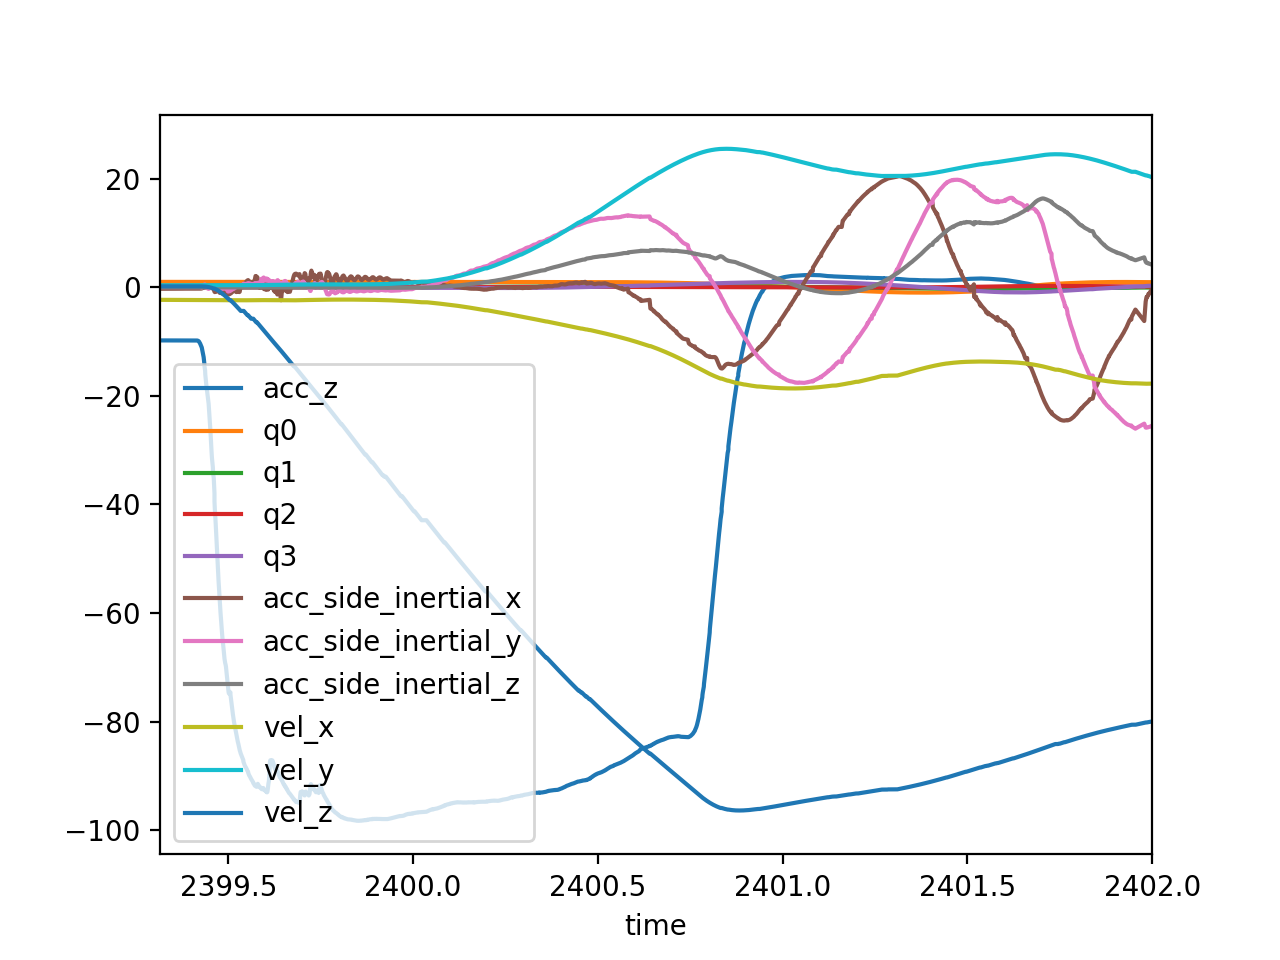

In [12]:
imu.drop(['acc_'+a for a in ['x', 'y']]+['rate_'+a for a in ['x', 'y', 'z']]+['dt'], 1)[liftoff:burnout+1].plot()

In [13]:
ms5611 = pd.read_csv('./20170520_roro1_testflight/imu_coupler_bay/ms5611.csv', index_col='time')
#ms5611 = pd.read_csv('./20170520_roro1_testflight/imu_nosecone/ms5611.csv', index_col='time')



<IPython.core.display.Javascript object>


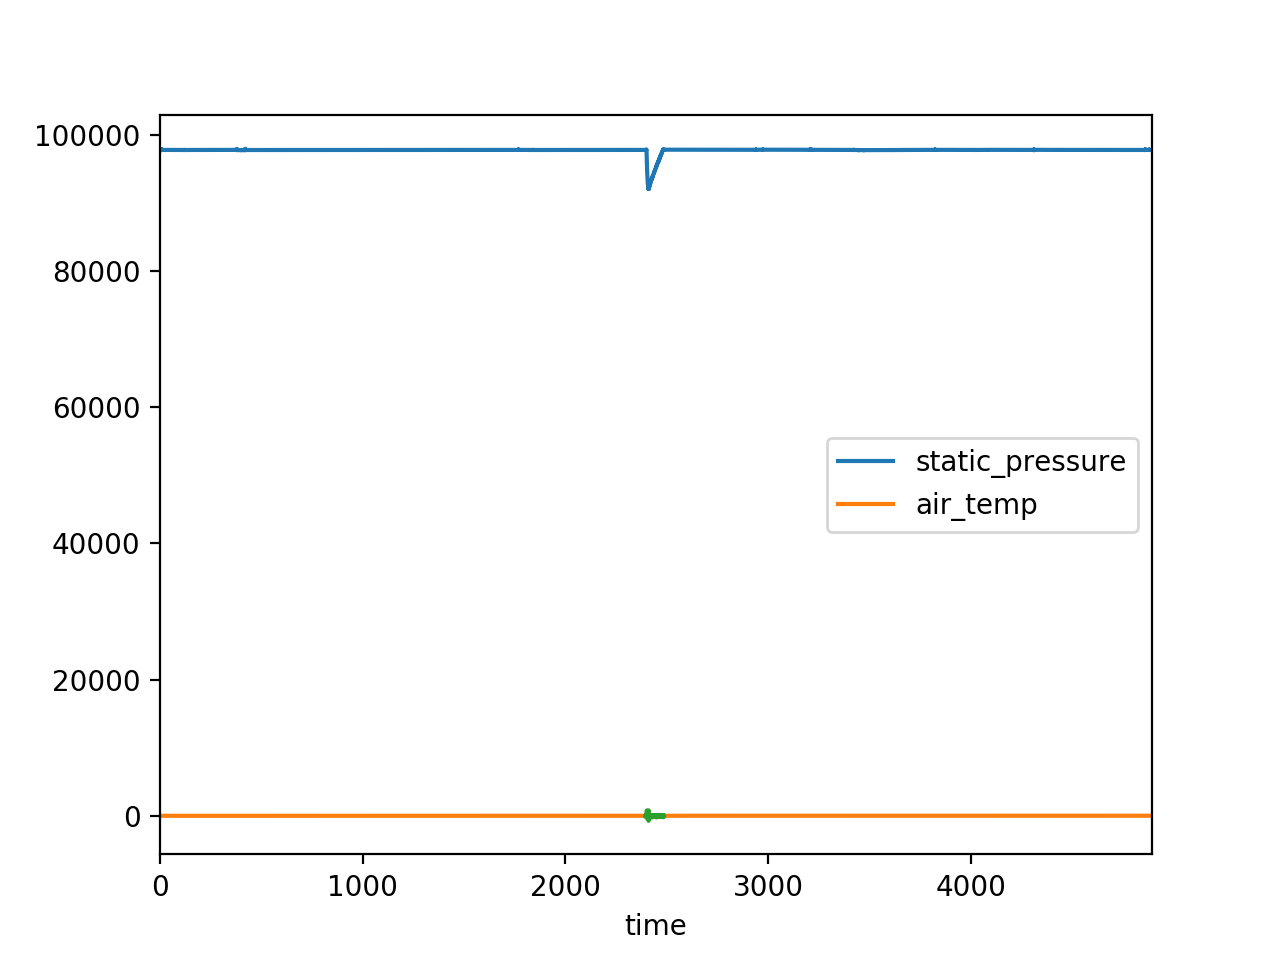

In [14]:
ms5611.plot()
altitude = 44330.8 - 4946.54 * pd.DataFrame(ms5611[liftoff-5:touchdown+5]['static_pressure'])**0.1902632;
altitude['dt'] = pd.DataFrame(altitude.index.values, index=altitude.index).diff()


In [15]:
(altitude['static_pressure'].diff()/altitude['dt']).plot()